In [20]:
#import relevant packages

import pandas as pd
import numpy as np

#import relevant packages
from matplotlib import cm
import matplotlib.pyplot as plt
from price_series_clustering import *
# from TES_plotting import *

import seaborn as sns
import os

from matplotlib import rc,rcParams
from matplotlib.ticker import StrMethodFormatter
import matplotlib.font_manager as font_manager

In [2]:
!pip3 install --upgrade pip
!pip3 install scikit-learn

In [2]:
def plotparams():
    """
    Format plots
    """
    plt.rcParams['font.sans-serif'] = "Times New Roman"
    plt.rcParams['font.family'] = "Times New Roman"
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["font.size"] = "15"

    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 'x-large'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 'large'
    plt.rcParams['ytick.labelsize'] = 'large'
    plt.rcParams['xtick.top'] = True
    plt.rcParams['ytick.right'] = True
    plt.rcParams['savefig.dpi'] = 900
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['xtick.major.pad']='8'
    plt.rcParams['ytick.major.pad']='8'
    # plt.rcParams['figure.figsize'] = 6.4, 4.8 # 1.33, matplotlib default
    # plt.rcParams['figure.figsize'] = 4.792, 3.458 # 1.38577, Igor my default
    # plt.rcParams['figure.figsize'] = 5.0, 4.0 # 1.25
    plt.rcParams['figure.figsize'] = 5.0, 3.75 # 1.33, fits 4x in ppt slide
    plt.rcParams['xtick.major.size'] = 4 # default 3.5
    plt.rcParams['ytick.major.size'] = 4 # default 3.5
    plt.rcParams['xtick.minor.size'] = 2.5 # default 2
    plt.rcParams['ytick.minor.size'] = 2.5 # default 2
    global font
    font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=15)

## read in the base parameters file
This file, "TES_Assumptions_2023.xlsx" is kept up to date
The price profiles parameters are not filled in

In [3]:
#conversion 
conversion = pd.read_excel("TES_Assumptions_2023.xlsx",header =1,sheet_name="BESS").loc[1,'Conversion rate']
conversion #INR per USD

82.3723229

In [21]:
base = pd.read_excel("TES_Assumptions_2023.xlsx",header=2).iloc[:,2:].set_index('Variable Name',drop=True).T.reset_index(drop=True)
base.head()

Variable Name,fname_price,fname_solar,fname_wind,fname_demand,fname_w,fname_map,fname_modeled_indices,W,T,N,...,eta_self,eta_charge,eta_discharge,coal_emf,BaselineEmissions,emissions_percent,TES_setting,coal_setting,retire_setting,coal_limit
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,168.0,23.0,...,0.0,0.95,0.95,0.97,0.0,1.0,0.0,0.0,0.0,500.0
1,$/MWh,NaN,NaN,NaN,<string>,<string>,<string>,weeks,hours,weeks,...,self discharge efficiency of Li-ion,charging efficiency,discharging efficiency,tCO2/MWh,variable,NaN,bin,bin,bin,MW
2,path for the CSV filename pointing to the ener...,NaN,NaN,NaN,path for filename pointing to the weights of t...,path for the filename pointing to the mapping ...,path for the filename pointing to the indices ...,Number of weeks in the year,Number of hours in a week,Number of representative weeks,...,self-discharge rate for battery storage,charging efficiency of battery storage,discharging efficiency for battery storage,emissions factor of coal plant,baseline emissions of the system with coal,percentage of the baseline emissions that is a...,1 if TES retrofits is taken out,setting that determines if coal is forced (1 f...,1 if coal is forced to retire,coal capacity size
3,"[1], [2]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,[37],NaN,NaN,NaN,NaN,NaN,NaN
4,This filename changes based on the price profi...,NaN,NaN,NaN,This filename changes based on the associated ...,This filename changes based on the associated ...,This filename changes based on the associated ...,conditional on if this uses representative weeks,conditional on if this uses representative weeks,"23 representative weeks were chosen, because i...",...,NaN,NaN,NaN,0.788 for Trombay,NaN,NaN,NaN,NaN,NaN,NaN


## Setting local test files

In [7]:
#set price profiles and clustering parameters
TES_parameters = base.copy()

#set folder for outputs
folder = 'sample/'

#set folder for inputs 
folder_fullyear = 'data/full_year_prices/'

#set price profile file name 
price_profile = 'REEDS_2030_MH.csv'

#set number of clusters in param file
n_clusters = 23
TES_parameters.loc[0,"N"]=n_clusters

price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])
    
    #perform clustering with same price profile and variable number of clusters
kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

# WEIGHTS #
    #find the weights 
weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

price_clusters_array=[]

for cluster in cluster_values:

    price_clusters_array.append(X[closest[cluster]])

price_clusters_df = round(pd.DataFrame(price_clusters_array),2) #$1k/MWh 

# PRICE PROFILE #
    #download price profile to csv in price folder
price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


# MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


# MODELED INDICES #
    #write to csv
closest_df = pd.DataFrame(closest)
closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

#save to params file
TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile

TES_parameters.to_csv('sample/parameters/TrombayU5_base.csv', index=False)


# Capacity Expansion Model files

In [22]:
def clustering_cem(EP, n_clusters = 23, n_cluster_hours = 24*7*3):
    # import all series from csv file

    t  = np.array(range(len(EP)))

    # remove trailing days
    diff = len(EP[0])%(n_cluster_hours) # see if hours divides the number of hours in profile

    EP2 = EP[:,0:len(EP[0])-diff] # remove trailing hours

    #trim
    trimmed = EP[:,0:len(EP[0])-24]

    #initialize
    init_array = np.zeros((52,n_cluster_hours))

    #normalize

    for i in np.arange(3):
        #put in the initial array and normalize
        init_array[:,i*168:168*(i+1)] = (trimmed[i]/np.max(trimmed[i])).reshape(52,168)

    X = init_array


    df_uci_pivot = pd.DataFrame(X, columns = range(n_cluster_hours))

    # Kmeans fit
    # since algorithm is non-deterministic the result will depend on initial seed. Set n_init to determine how many initial random clusters are chosen (higher will result in better minimum). Set random state to ensure the same output each time its run
    kmeans = KMeans(n_clusters=n_clusters,init ='k-means++',n_init = 1000,random_state = 1)

    cluster_found = kmeans.fit_predict(X)
    cluster_found_sr = pd.Series(cluster_found, name='cluster')
    df_uci_pivot = df_uci_pivot.set_index(cluster_found_sr, append=True )

    # Find closest points to centroid
    closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
    cluster_values = sorted(df_uci_pivot.index.get_level_values('cluster').unique())


    return kmeans, df_uci_pivot, cluster_values,X, closest


In [23]:
# read in the NREL bin in the same state, and don't need to shift 

solar_df = pd.read_csv('tutorial_share/solar_variability_MH.csv')['Solar_29_A103']
wind_df = pd.read_csv('tutorial_share/wind_variability_MH.csv')['Wind_29_A103']

#read in demand data for UP 

demand_UP_2030 = pd.read_csv('tutorial_share/Uttar Pradesh_2030.csv')
demand_UP_2030_total = demand_UP_2030.sum(axis=1)

# these are then normlaized in the clustering function
solar_year = pd.DataFrame({'cf': solar_df}).reset_index(drop=True)
wind_year = pd.DataFrame({'cf': wind_df}).reset_index(drop=True)
demand_year = pd.DataFrame({'demand': demand_UP_2030_total}).reset_index(drop=True)

#create array of all three that will feed into clustring function
all_array = np.array([solar_year,wind_year, demand_year])


/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_2202/1759621746.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  demand_UP_2030_total = demand_UP_2030.sum(axis=1)


In [24]:
#set price profiles and clustering parameters
TES_parameters = base.copy()

#set folder for outputs ### CHANGE THIS FOLDER / ITERATE OVER THIS
folder = 'model/CEM/'

#set folder for inputs 
folder_fullyear = 'data/full_year_prices/'

#set price profile file name 
price_profile = 'REEDS_2030_MH.csv'

#set number of clusters in param file
n_clusters = 23
TES_parameters.loc[0,"N"]=n_clusters

price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])
    
    #perform clustering with same price profile and variable number of clusters
kmeans, df_uci_pivot, cluster_values, X, closest=clustering_cem(EP = all_array,n_clusters=n_clusters)


# WEIGHTS #
    #find the weights 
weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

price_clusters_array=[]

for cluster in cluster_values:

    price_clusters_array.append(X[closest[cluster]])

price_clusters_df = round(pd.DataFrame(price_clusters_array),2) #$1k/MWh 

# PRICE PROFILE #
    #download price profile to csv in price folder
price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile

# MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


# MODELED INDICES #
    #write to csv
closest_df = pd.DataFrame(closest)
closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

#save to params file
TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile



In [25]:
# set the baseline emissions here 
BASE_EMISSIONS = 185164.203358 #379608

In [26]:
#reshape the yearly profiles so  you can access them
solar_reshaped = np.array(solar_year['cf'][0:(52*168)]).reshape((52,168))
wind_reshaped = np.array(wind_year['cf'][0:(52*168)]).reshape((52,168))
demand_reshaped = np.array(demand_year['demand'][0:(52*168)]).reshape((52,168))

#initialize the clusters df6``
solar_clusters = pd.DataFrame(np.zeros((23,168)))
wind_clusters = pd.DataFrame(np.zeros((23,168)))
demand_clusters = pd.DataFrame(np.zeros((23,168)))

#create the dataframe using the closests dictionary assignmetn 
index=0
for i in closest_df.iloc[:,0]:
    solar_clusters.iloc[index,:] = solar_reshaped[i]
    wind_clusters.iloc[index,:] = wind_reshaped[i]
    demand_clusters.iloc[index,:] = demand_reshaped[i]
    index=index+1

solar_profile = 'solar.csv'
wind_profile = 'wind.csv'
demand_profile = 'demand.csv'


solar_clusters.to_csv(folder+'prices/'+str(n_clusters)+solar_profile,index=False)
wind_clusters.to_csv(folder+'prices/'+str(n_clusters)+wind_profile,index=False)
demand_clusters.to_csv(folder+'prices/'+str(n_clusters)+demand_profile,index=False)

TES_parameters.loc[0,"fname_solar"]=str(n_clusters)+solar_profile
TES_parameters.loc[0,"fname_wind"]=str(n_clusters)+wind_profile
TES_parameters.loc[0,"fname_demand"]=str(n_clusters)+demand_profile

#save to csvs
#BASE
TES_parameters.loc[0,"BaselineEmissions"] = 0
#something that forces coal model
TES_parameters.loc[0,"coal_setting"] = 1
TES_parameters.loc[0,"TES_setting"] = 0
TES_parameters.loc[0,"retire_setting"] = 0

#save file
TES_parameters.to_csv('model/CEM/parameters/CEM_base.csv', index=False)

#BASE + TES
TES_parameters.loc[0,"BaselineEmissions"] = 0
#something that PUTS IN TES option
TES_parameters.loc[0,"coal_setting"] = 0
TES_parameters.loc[0,"TES_setting"] = 2 #0
TES_parameters.loc[0,"retire_setting"] = 0
#save file
TES_parameters.to_csv('model/CEM/parameters/CEM_TES.csv', index=False)


#BASE + EMISSIONS 
TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS #216019.4417 #SET HERE BASED ON UPDATES

for emissions_percent in np.arange(0,1.1,0.1):
    TES_parameters.loc[0,"emissions_percent"] = emissions_percent
    #something that TAKES OUT TES option
    TES_parameters.loc[0,"TES_setting"] = 1
    TES_parameters.loc[0,"coal_setting"] = 0
    TES_parameters.loc[0,"retire_setting"] = 0
    #save file
    TES_parameters.to_csv('model/CEM/parameters/CEM_emissions'+str(int(emissions_percent*100))+'.csv', index=False)


#BASE + TES + EMISSIONS
TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS #216019.4417 #SET HERE BASED ON UPDATES

for emissions_percent in np.arange(0,1.1,0.1):
    TES_parameters.loc[0,"emissions_percent"] = emissions_percent
    #something that ALLOWS TES option
    TES_parameters.loc[0,"TES_setting"] = 2#0
    TES_parameters.loc[0,"coal_setting"] = 0
    TES_parameters.loc[0,"retire_setting"] = 0
    #save file
    TES_parameters.to_csv('model/CEM/parameters/CEM_emissions_TES'+str(int(emissions_percent*100))+'.csv', index=False)


## efficiency CEM

In [27]:
for eff in np.arange(0.35,0.45,0.01):  
    #save to csvs
    TES_parameters.loc[0,"steam_eff"] = eff

    #BASE
    TES_parameters.loc[0,"BaselineEmissions"] = 0
    #something that forces coal model
    TES_parameters.loc[0,"coal_setting"] = 1
    TES_parameters.loc[0,"TES_setting"] = 0
    TES_parameters.loc[0,"retire_setting"] = 0

    #save file
    TES_parameters.to_csv('model/CEM_eff/parameters/CEM_base_eff'+str(int(eff*100))+'.csv', index=False) 

    #BASE + TES
    TES_parameters.loc[0,"BaselineEmissions"] = 0
    #something that PUTS IN TES option
    TES_parameters.loc[0,"coal_setting"] = 0
    TES_parameters.loc[0,"TES_setting"] = 2#0
    TES_parameters.loc[0,"retire_setting"] = 0
    #save file
    TES_parameters.to_csv('model/CEM_eff/parameters/CEM_TES_eff'+str(int(eff*100))+'.csv', index=False)


    #BASE + EMISSIONS 
    TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS #SET HERE BASED ON UPDATES

    for emissions_percent in np.arange(0,1.1,0.1):
        TES_parameters.loc[0,"emissions_percent"] = emissions_percent
        #something that TAKES OUT TES option
        TES_parameters.loc[0,"TES_setting"] = 1
        TES_parameters.loc[0,"coal_setting"] = 0
        TES_parameters.loc[0,"retire_setting"] = 0
        #save file
        TES_parameters.to_csv('model/CEM_eff/parameters/CEM_eff'+str(int(eff*100))+'emissions'+str(int(emissions_percent*100))+'.csv', index=False)

    #BASE + TES + EMISSIONS
    TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS #SET HERE BASED ON UPDATES

    for emissions_percent in np.arange(0,1.1,0.1):
        TES_parameters.loc[0,"emissions_percent"] = emissions_percent
        #something that ALLOWS TES option
        TES_parameters.loc[0,"TES_setting"] = 2#0
        TES_parameters.loc[0,"coal_setting"] = 0
        TES_parameters.loc[0,"retire_setting"] = 0
        #save file
        TES_parameters.to_csv('model/CEM_eff/parameters/CEM_TES_eff'+str(int(eff*100))+'emissions'+str(int(emissions_percent*100))+'.csv', index=False)


## age CEM

In [28]:

#reset the efficiency
TES_parameters.loc[0,"steam_eff"] = base.loc[0,"steam_eff"]

In [29]:
for life in np.arange(5,45,5):  
    #remaining lifetime 5 to 45 yrs
    TES_parameters.loc[0,"life"] = life

    #BASE
    TES_parameters.loc[0,"BaselineEmissions"] = 0
    #something that forces coal model
    TES_parameters.loc[0,"coal_setting"] = 1
    TES_parameters.loc[0,"TES_setting"] = 0
    TES_parameters.loc[0,"retire_setting"] = 0

    #save file
    TES_parameters.to_csv('model/CEM_age/parameters/CEM_base_life'+str(int(life))+'.csv', index=False) 

    #BASE + TES
    TES_parameters.loc[0,"BaselineEmissions"] = 0
    #something that PUTS IN TES option
    TES_parameters.loc[0,"coal_setting"] = 0
    TES_parameters.loc[0,"TES_setting"] = 2#0
    TES_parameters.loc[0,"retire_setting"] = 0
    #save file
    TES_parameters.to_csv('model/CEM_age/parameters/CEM_TES_life'+str(int(life))+'.csv', index=False)


    #BASE + EMISSIONS 
    TES_parameters.loc[0,"BaselineEmissions"] =BASE_EMISSIONS #216019.4417 #SET HERE BASED ON UPDATES

    for emissions_percent in np.arange(0,1.1,0.1):
        TES_parameters.loc[0,"emissions_percent"] = emissions_percent
        #something that TAKES OUT TES option
        TES_parameters.loc[0,"TES_setting"] = 1
        TES_parameters.loc[0,"coal_setting"] = 0
        TES_parameters.loc[0,"retire_setting"] = 0
        #save file
        TES_parameters.to_csv('model/CEM_age/parameters/CEM_life'+str(int(life))+'emissions'+str(int(emissions_percent*100))+'.csv', index=False)

    #BASE + TES + EMISSIONS
    TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS#216019.4417 #SET HERE BASED ON UPDATES

    for emissions_percent in np.arange(0,1.1,0.1):
        TES_parameters.loc[0,"emissions_percent"] = emissions_percent
        #something that ALLOWS TES option
        TES_parameters.loc[0,"TES_setting"] = 2#0
        TES_parameters.loc[0,"coal_setting"] = 0
        TES_parameters.loc[0,"retire_setting"] = 0
        #save file
        TES_parameters.to_csv('model/CEM_age/parameters/CEM_TES_life'+str(int(life))+'emissions'+str(int(emissions_percent*100))+'.csv', index=False)


## energy storage CEM

In [30]:
#reset the life
TES_parameters.loc[0,"life"] = base.loc[0,"life"]

In [31]:
for percentage in np.linspace(0.2,2,10):  

    storage_cost = percentage*base.loc[0,"cost_tank"]
    #changing the storage cost
    TES_parameters.loc[0,'cost_tank'] = storage_cost

    #BASE
    TES_parameters.loc[0,"BaselineEmissions"] = 0
    #something that forces coal model
    TES_parameters.loc[0,"coal_setting"] = 1
    TES_parameters.loc[0,"TES_setting"] = 0
    TES_parameters.loc[0,"retire_setting"] = 0

    #save file
    TES_parameters.to_csv('model/CEM_storage/parameters/CEM_base_storage'+str(int(percentage*100))+'.csv', index=False) 

    #BASE + TES
    TES_parameters.loc[0,"BaselineEmissions"] = 0
    #something that PUTS IN TES option
    TES_parameters.loc[0,"coal_setting"] = 0
    TES_parameters.loc[0,"TES_setting"] = 2#0
    TES_parameters.loc[0,"retire_setting"] = 0
    #save file
    TES_parameters.to_csv('model/CEM_storage/parameters/CEM_TES_storage'+str(int(percentage*100))+'.csv', index=False)


    #BASE + EMISSIONS 
    TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS#216019.4417 #SET HERE BASED ON UPDATES

    for emissions_percent in np.arange(0,1.1,0.1):
        TES_parameters.loc[0,"emissions_percent"] = emissions_percent
        #something that TAKES OUT TES option
        TES_parameters.loc[0,"TES_setting"] = 1
        TES_parameters.loc[0,"coal_setting"] = 0
        TES_parameters.loc[0,"retire_setting"] = 0
        #save file
        TES_parameters.to_csv('model/CEM_storage/parameters/CEM_storage'+str(int(percentage*100))+'emissions'+str(int(emissions_percent*100))+'.csv', index=False)

    #BASE + TES + EMISSIONS
    TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS#216019.4417 #SET HERE BASED ON UPDATES

    for emissions_percent in np.arange(0,1.1,0.1):
        TES_parameters.loc[0,"emissions_percent"] = emissions_percent
        #something that ALLOWS TES option
        TES_parameters.loc[0,"TES_setting"] = 2#0
        TES_parameters.loc[0,"coal_setting"] = 0
        TES_parameters.loc[0,"retire_setting"] = 0
        #save file
        TES_parameters.to_csv('model/CEM_storage/parameters/CEM_TES_storage'+str(int(percentage*100))+'emissions'+str(int(emissions_percent*100))+'.csv', index=False)


## contracts CEM 

changes the demand profile to be flat

adding clustering parameters

In [32]:
BASE_EMISSIONS = 221621.5
#RESEST
TES_parameters.loc[0,"cost_tank"] = base.loc[0,"cost_tank"]

#set to flat demand profile
demand_flat = pd.DataFrame(np.ones((23,168)))*np.max(np.max(demand_clusters))
demand_flat_profile = 'demand_flat.csv'
demand_flat.to_csv('model/CEM_flat/prices/'+str(n_clusters)+demand_flat_profile,index=False)
TES_parameters.loc[0,"fname_demand"]=str(n_clusters)+demand_flat_profile

#save to csvs
#BASE
TES_parameters.loc[0,"BaselineEmissions"] = 0
#something that forces coal model
TES_parameters.loc[0,"coal_setting"] = 1
TES_parameters.loc[0,"TES_setting"] = 0
TES_parameters.loc[0,"retire_setting"] = 0

#save file
TES_parameters.to_csv('model/CEM_flat/parameters/CEM_base_flat.csv', index=False)

#BASE + TES
TES_parameters.loc[0,"BaselineEmissions"] = 0
#something that PUTS IN TES option
TES_parameters.loc[0,"coal_setting"] = 0
TES_parameters.loc[0,"TES_setting"] = 2#0
TES_parameters.loc[0,"retire_setting"] = 0
#save file
TES_parameters.to_csv('model/CEM_flat/parameters/CEM_TES_flat.csv', index=False)


#BASE + EMISSIONS 
TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS#216019.4417 #SET HERE BASED ON UPDATES

for emissions_percent in np.arange(0,1.1,0.1):
    TES_parameters.loc[0,"emissions_percent"] = emissions_percent
    #something that TAKES OUT TES option
    TES_parameters.loc[0,"TES_setting"] = 1
    TES_parameters.loc[0,"coal_setting"] = 0
    TES_parameters.loc[0,"retire_setting"] = 0
    #save file
    TES_parameters.to_csv('model/CEM_flat/parameters/CEM_emissions_flat'+str(int(emissions_percent*100))+'.csv', index=False)

#BASE + TES + EMISSIONS
TES_parameters.loc[0,"BaselineEmissions"] = BASE_EMISSIONS #SET HERE BASED ON UPDATES

for emissions_percent in np.arange(0,1.1,0.1):
    TES_parameters.loc[0,"emissions_percent"] = emissions_percent
    #something that ALLOWS TES option
    TES_parameters.loc[0,"TES_setting"] = 2#0
    TES_parameters.loc[0,"coal_setting"] = 0
    TES_parameters.loc[0,"retire_setting"] = 0
    #save file
    TES_parameters.to_csv('model/CEM_flat/parameters/CEM_emissions_TES_flat'+str(int(emissions_percent*100))+'.csv', index=False)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


# parameters files saved to "temp_eff" folder

This sensitivity analysis explores the effect of increasing the maximum temperatures, and the associated efficiency tradeoff 



In [19]:
# read in parameters file 
TES_parameters = base.copy()
#set price profile file name 
price_profile = 'REEDS_2030_MH.csv'

In [20]:
#set price profiles and clustering parameters
#set folder for outputs
folder = 'model/temp_eff/'

#set folder for inputs 
folder_fullyear = 'model/full_year_prices/'

#set number of clusters in param file
n_clusters = 23
TES_parameters.loc[0,"N"]=n_clusters

price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])
    
    #perform clustering with same price profile and variable number of clusters
kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

# WEIGHTS #
    #find the weights 
weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

price_clusters_array=[]

for cluster in cluster_values:

    price_clusters_array.append(X[closest[cluster]])

price_clusters_df = round(pd.DataFrame(price_clusters_array),2) #$1k/MWh 

# PRICE PROFILE #
    #download price profile to csv in price folder
price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


# MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


# MODELED INDICES #
    #write to csv
closest_df = pd.DataFrame(closest)
closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

#save to params file
TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile



In [21]:
#read in the aspen outputs
outputs_maxtemps_df = pd.read_csv('data/aspen_data/output_df_maxtemps.csv',index_col='Unnamed: 0')

In [22]:
outputs_maxtemps_df

,temp565,temp665,temp765,temp865,temp965
steam_eff,4.096261e-01,4.096261e-01,4.096261e-01,4.096261e-01,4.096261e-01
Qs,-3.477154e+06,-3.477154e+06,-3.477154e+06,-3.477154e+06,-3.477154e+06
P_out_net,5.309701e+02,5.309701e+02,5.309701e+02,5.309701e+02,5.309701e+02
F_salt,3.854680e+03,2.814957e+03,2.209820e+03,1.811955e+03,1.528848e+03
deltaA,2.500069e+01,1.250007e+02,2.250007e+02,3.250007e+02,4.250007e+02
deltaB,1.393964e+02,2.112346e+02,2.836991e+02,3.570836e+02,4.318593e+02
deltaC,7.304895e+01,1.207707e+02,1.691163e+02,2.183349e+02,2.688395e+02
deltaD,2.550217e+02,2.550168e+02,2.550240e+02,2.550002e+02,2.550014e+02
flowsteamPeak,3.428162e+02,3.428162e+02,3.428162e+02,3.428162e+02,3.428162e+02
coal_steam_eff,4.096261e-01,4.096261e-01,4.096261e-01,4.096261e-01,4.096261e-01


In [23]:
#temp_list =  [565, 665, 765, 865, 965] #peak temperatures

for col in outputs_maxtemps_df.columns:
    temperature = int(col.replace('temp',''))
    # change temperature
    TES_parameters.loc[0,'T_hot'] = int(temperature)+273 #K
    TES_parameters.loc[0,"deltaT_A"] = outputs_maxtemps_df.loc['deltaA',col]
    TES_parameters.loc[0,"deltaT_B"] = outputs_maxtemps_df.loc['deltaB',col]
    TES_parameters.loc[0,"deltaT_C"] = outputs_maxtemps_df.loc['deltaC',col]
    TES_parameters.loc[0,"deltaT_D"] = outputs_maxtemps_df.loc['deltaD',col]
    TES_parameters.loc[0,'steam_eff'] = outputs_maxtemps_df.loc['steam_eff',col]
    TES_parameters.loc[0,'flowSalt_max'] = outputs_maxtemps_df.loc['F_salt',col]/1000


    for min_hours in np.arange(0,11):
    #for min_hours in [2]:
        TES_parameters.loc[0,'min_hours'] = min_hours

    # save parameter file
        TES_parameters.to_csv('model/temp_eff/parameters/TrombayU5' 
                + str(int(temperature)) + '_'+ str(int(min_hours)) + 'hrs.csv', index=False)



# parameters saved to "base_age" folder

sensitivity with age and the base case (MH 2030 profile)
min_hours will be zero 
age range - 25 to 50 


In [24]:
#read in the parameters file
TES_parameters = base.copy()

In [25]:
#set price profiles and clustering parameters
#set folder for outputs
folder = 'model/base_age/'

#set folder for inputs 
folder_fullyear = 'data/full_year_prices/'

#set price profile file name 
price_profile = 'REEDS_2030_MH.csv'

#set number of clusters in param file
n_clusters = 23
TES_parameters.loc[0,"N"]=n_clusters

price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])
    
    #perform clustering with same price profile and variable number of clusters
kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

# WEIGHTS #
    #find the weights 
weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

price_clusters_array=[]

for cluster in cluster_values:

    price_clusters_array.append(X[closest[cluster]])

price_clusters_df = round(pd.DataFrame(price_clusters_array),2) #$1k/MWh 

# PRICE PROFILE #
    #download price profile to csv in price folder
price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


# MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


# MODELED INDICES #
    #write to csv
closest_df = pd.DataFrame(closest)
closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

#save to params file
TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile



In [26]:

#set age range
lifetimes =  np.arange(20,51,1)


for life in lifetimes:

    # change temperature
    TES_parameters.loc[0,'life'] = life

    # for min_hours in np.arange(0,11):
    # #for min_hours in [2]:
    #     TES_parameters.loc[0,'min_hours'] = min_hours

    # save parameter file
    TES_parameters.to_csv('model/base_age/parameters/TrombayU5' 
                '_'+ str(int(life))+ '.csv', index=False)



# parameters files saved to "storage_cost" folder
sensitivity analysis with the effect of changing the cost of storage 


In [27]:
#read in the parameters file
TES_parameters = base.copy()

In [28]:
#set price profiles and clustering parameters
#set folder for outputs
folder = 'model/storage_cost/'

#set folder for inputs 
folder_fullyear = 'data/full_year_prices/'

#set price profile file name 
price_profile = 'REEDS_2030_MH.csv'

#set number of clusters in param file
n_clusters = 23
TES_parameters.loc[0,"N"]=n_clusters

price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])
    
    #perform clustering with same price profile and variable number of clusters
kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

# WEIGHTS #
    #find the weights 
weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

price_clusters_array=[]

for cluster in cluster_values:

    price_clusters_array.append(X[closest[cluster]])

price_clusters_df = round(pd.DataFrame(price_clusters_array),2) #$1k/MWh 

# PRICE PROFILE #
    #download price profile to csv in price folder
price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


# MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


# MODELED INDICES #
    #write to csv
closest_df = pd.DataFrame(closest)
closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

#save to params file
TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile



In [29]:

#set storage costs
storage_costs = np.linspace(0.2,2,10)*TES_parameters.loc[0,"cost_tank"]


for storage_cost in storage_costs:

    # change temperature
    TES_parameters.loc[0,'cost_tank'] = storage_cost

    for min_hours in np.arange(0,11):
    #for min_hours in [2]:
        TES_parameters.loc[0,'min_hours'] = min_hours

    # save parameter file
        TES_parameters.to_csv('model/storage_cost/parameters/TrombayU5' 
                '_'+ str(int(storage_cost))+ '_'+ str(int(min_hours)) + 'hrs.csv', index=False)



# parameters files for industrial and multiple price periods

In [32]:
# read in parameters file 
TES_parameters = base.copy()

In [34]:
#initialize price dictionary for plotting
price_dict = {}

#set n_clusters
n_clusters = 23

#set folder for outputs
folder = 'model/industrial/'

#set folder for inputs 
folder_fullyear = 'data/NREL_2030_fullyear_profiles/'

#put files there
ReEDS_2030 = pd.read_csv('SA_USD_Base_DA_2030 9.21.2022.csv')

for state_name in ReEDS_2030["Child Name"].unique():

    ReEDS_2030_array = np.array(ReEDS_2030[ReEDS_2030['Child Name']==state_name]['Value'].reset_index(drop=True)) #used in the clustering
    ReEDS_2030_series = ReEDS_2030[ReEDS_2030['Child Name']==state_name]['Value'].reset_index(drop=True)
    ReEDS_2030_series.to_csv(folder_fullyear + state_name + '.csv',index=False)

#filenames of price profiles
#price_profiles_list = os.listdir(folder_fullyear)
price_profiles_list = ['MAHARASHTRA.csv','UTTAR PRADESH.csv','GUJARAT.csv']

#iterate
for price_profile in price_profiles_list:

    #set number of clusters in param file
    TES_parameters.loc[0,"N"]=n_clusters

    #read in the array and change to $1k/MWh
    price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])

    #save to price dict for plotting purposes
    price_dict[price_profile.replace('.csv','')]  = price_profile_array

    #perform clustering with same price profile and variable number of clusters
    kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

    #rename price profile 
    price_profile=price_profile.replace('&','').replace(' ','_')
    
    # WEIGHTS #
    #find the weights 
    weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
    weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
    TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

    price_clusters_array=[]

    for cluster in cluster_values:

        price_clusters_array.append(X[closest[cluster]])

    price_clusters_df = round(pd.DataFrame(price_clusters_array),2) # $/MWh

   
    #price_clusters_df[price_clusters_df>price_cap] = price_cap


    # PRICE PROFILE #
    #download price profile to csv in price folder
    price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
    TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


    # MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
    fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
    pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
    TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


    # MODELED INDICES #
    #write to csv
    closest_df = pd.DataFrame(closest)
    closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

    #save to params file
    TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile


    #change the industrial deamnd 
    for demand in np.linspace(0,0.7,8):
        # change lifetime
        TES_parameters.loc[0,'x'] = demand
        
        for min_hours in np.arange(0,11):
            TES_parameters.loc[0,'min_hours'] = min_hours

            # save the file
            TES_parameters.to_csv(folder+'parameters/TrombayU5_' 
            + '_' + str(int(demand*100))+ '_'+ str(int(min_hours))+'hrs_'+ price_profile, index=False)
        

# parameters files saved to "industrial" folder

This sensitivity analysis explores the effect of including local industrial demand and with the 3 different price profiles



In [ ]:
# read in parameters file 
TES_parameters = base.copy()

In [ ]:

#set n_clusters
n_clusters = 23

#set folder for outputs
folder = 'model/industrial/'

#set folder for inputs 
folder_fullyear = 'data/full_year_prices/'

#filenames of the price profiles 
#price_profiles_list = ["IEX2021.csv", 'REEDS_2030_MH.csv',"REEDS_2050_MH.csv"]
price_profiles_list = ['REEDS_2030_MH.csv']
 
# start with getting price profile clusters 
for price_profile in price_profiles_list:

    #set number of clusters in param file
    TES_parameters.loc[0,"N"]=n_clusters

    price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])
    
    #perform clustering with same price profile and variable number of clusters
    kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

    # WEIGHTS #
    #find the weights 
    weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
    weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
    TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

    price_clusters_array=[]

    for cluster in cluster_values:

        price_clusters_array.append(X[closest[cluster]])

    price_clusters_df = round(pd.DataFrame(price_clusters_array),2) #$1k/MWh 

    # PRICE PROFILE #
    #download price profile to csv in price folder
    price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
    TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


    # MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
    fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
    pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
    TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


    # MODELED INDICES #
    #write to csv
    closest_df = pd.DataFrame(closest)
    closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

    #save to params file
    TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile


    #change the industrial deamnd 
    for demand in np.linspace(0,0.7,8):
        # change lifetime
        TES_parameters.loc[0,'x'] = demand

        for min_hours in np.arange(2,11):
            TES_parameters.loc[0,'min_hours'] = min_hours

            # save the file
            TES_parameters.to_csv(folder+'parameters/TrombayU5_' 
            + '_' + str(int(demand*100))+ '_'+ str(int(min_hours))+'hrs_'+ price_profile, index=False)
        

# parameters files saved to "bottomup" folder

These parameter files explore the sensitivity to all the price profiles for each state in 2030

In [67]:
# read in parameters file 
TES_parameters = base.copy()


In [68]:
#initialize price dictionary for plotting
price_dict = {}

#set n_clusters
n_clusters = 23

#set folder for outputs
folder = 'model/bottomup/'

#set folder for inputs 
folder_fullyear = 'data/NREL_2030_fullyear_profiles/'

#put files there
ReEDS_2030 = pd.read_csv('SA_USD_Base_DA_2030 9.21.2022.csv')

for state_name in ReEDS_2030["Child Name"].unique():
    ReEDS_2030_array = np.array(ReEDS_2030[ReEDS_2030['Child Name']==state_name]['Value'].reset_index(drop=True)) #used in the clustering
    ReEDS_2030_series = ReEDS_2030[ReEDS_2030['Child Name']==state_name]['Value'].reset_index(drop=True)
    ReEDS_2030_series.to_csv(folder_fullyear + state_name + '.csv',index=False)

#filenames of price profiles
price_profiles_list = os.listdir(folder_fullyear)

#iterate
for price_profile in price_profiles_list:

    #set number of clusters in param file
    TES_parameters.loc[0,"N"]=n_clusters

    #read in the array and change to $1k/MWh
    price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])

    #save to price dict for plotting purposes
    price_dict[price_profile.replace('.csv','')]  = price_profile_array

    #perform clustering with same price profile and variable number of clusters
    kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

    #rename price profile 
    price_profile=price_profile.replace('&','').replace(' ','_')
    
    # WEIGHTS #
    #find the weights 
    weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
    weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
    TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

    price_clusters_array=[]

    for cluster in cluster_values:

        price_clusters_array.append(X[closest[cluster]])

    price_clusters_df = round(pd.DataFrame(price_clusters_array),2) # $/MWh



    # PRICE PROFILE #
    #download price profile to csv in price folder
    price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
    TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


    # MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
    fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
    pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
    TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


    # MODELED INDICES #
    #write to csv
    closest_df = pd.DataFrame(closest)
    closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

    #save to params file
    TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile




    repweeks_df = df_uci_pivot.reset_index(drop=True)
    repweeks_df_clean = np.zeros(repweeks_df.shape)


    print(price_profile)

    for min_hours in np.arange(0,3):
        TES_parameters.loc[0,'min_hours'] = min_hours
     
        #SAVE FILE
        TES_parameters.to_csv(folder+'parameters/TrombayU5_' + str(int(min_hours)) + 'hrs_' + price_profile, index=False)




JAMMU__KASHMIR.csv
NAGALAND.csv
PUNJAB.csv
UTTARAKHAND.csv
DELHI.csv
ANDHRA_PRADESH.csv
DADRA__NAGAR_HAVELI.csv
MANIPUR.csv
JHARKHAND.csv
TAMIL_NADU.csv
BHUTAN.csv
ASSAM.csv
RAJASTHAN.csv
BANGLADESH.csv
TRIPURA.csv
KARNATAKA.csv
MIZORAM.csv
PUDUCHERRY.csv
UTTAR_PRADESH.csv
SIKKIM.csv
CHHATTISGARH.csv
MADHYA_PRADESH.csv
ARUNACHAL_PRADESH.csv
NEPAL.csv
DAMAN__DIU.csv
ODISHA.csv
CHANDIGARH.csv
GOA.csv
MEGHALAYA.csv
GUJARAT.csv
KERALA.csv
TELANGANA.csv
HARYANA.csv
MAHARASHTRA.csv
HIMACHAL_PRADESH.csv
WEST_BENGAL.csv
BIHAR.csv


In [313]:

new_list = list(price_dict.keys())

In [37]:
new_list = list(price_dict.keys())

In [41]:
new_list.remove('BANGLADESH')

In [43]:
new_list.remove('CHHATTISGARH')

In [46]:
new_list.remove('CHANDIGARH')

# Deep dive on Uttar Pradesh

### parameters saved to folder "UttarPradesh"

- set the prices
- set the coal plant types
- set the coal financial data 

coal_FOM = parameters_dict["coal_FOM"]

emissions_rate = parameters_dict["emissions_rate"]

coal_fuel_cost = parameters_dict["coal_fuel_cost"]

coal_VOM = parameters_dict["coal_VOM"]

carbon_price = parameters_dict["carbon_price"]



In [37]:
#set folder for outputs
folder = 'model/UttarPradesh/'

# read in parameters file 
TES_parameters = base.copy()

### 2030 or 2050 NREL profile

In [38]:

# #set folder for inputs 
folder_fullyear = 'data/NREL_2030_fullyear_profiles/'

#filenames of price profiles you care about
price_profiles_list = ['UTTAR PRADESH.csv']

#iterate
for price_profile in price_profiles_list:

    #set number of clusters in param file
    TES_parameters.loc[0,"N"]=n_clusters

    #read in the array and change to $1k/MWh
    price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])
    
    #perform clustering with same price profile and variable number of clusters
    kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

    #rename price profile 
    price_profile=price_profile.replace('&','').replace(' ','_')
    
    # WEIGHTS #
    #find the weights 
    weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
    weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
    TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

    price_clusters_array=[]

    for cluster in cluster_values:

        price_clusters_array.append(X[closest[cluster]])

    price_clusters_df = round(pd.DataFrame(price_clusters_array),2) # $/MWh



    # PRICE PROFILE #
    #download price profile to csv in price folder
    price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
    TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


    # MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
    fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
    pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
    TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


    # MODELED INDICES #
    #write to csv
    closest_df = pd.DataFrame(closest)
    closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

    #save to params file
    TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile


    repweeks_df = df_uci_pivot.reset_index(drop=True)
    repweeks_df_clean = np.zeros(repweeks_df.shape)




## 2050 NREL profile

In [169]:
#set price cap 
#price_cap = 200 #$/MWh

#set n_clusters
n_clusters = 23

#set folder for inputs 
folder_fullyear = 'data/NREL_2050_fullyear_profiles/'

#put files there
ReEDS_2050 = pd.read_csv('data/SA_USD_Base_DA_2050 9.21.2022.csv')

for state_name in ReEDS_2030["Child Name"].unique():
    ReEDS_2050_array = np.array(ReEDS_2050[ReEDS_2050['Child Name']==state_name]['Value'].reset_index(drop=True)) #used in the clustering
    ReEDS_2050_series = ReEDS_2050[ReEDS_2050['Child Name']==state_name]['Value'].reset_index(drop=True)
    ReEDS_2050_series.to_csv(folder_fullyear + state_name +'_2050' + '.csv',index=False)

#filenames of price profiles
price_profiles_list = ['UTTAR PRADESH_2050.csv']

#iterate
for price_profile in price_profiles_list:

    #set number of clusters in param file
    TES_parameters.loc[0,"N"]=n_clusters

    #read in the array and change to $1k/MWh
    price_profile_array = np.array(pd.read_csv(folder_fullyear+price_profile).iloc[:,0])
    
    #perform clustering with same price profile and variable number of clusters
    kmeans, df_uci_pivot, cluster_values, X, closest=get_price_series_and_weights(EP = price_profile_array,n_clusters=n_clusters)

    #rename price profile 
    price_profile=price_profile.replace('&','').replace(' ','_')
    
    # WEIGHTS #
    #find the weights 
    weights_df = pd.DataFrame([df_uci_pivot.xs(w, level=1).shape[0] for w in cluster_values])
    
    #save the weights to csv in parameters folder
    weights_df.to_csv(folder + 'clustering_parameters/fname_w' + price_profile , index=False)
    
    #save filename to params file
    TES_parameters.loc[0,"fname_w"] = 'clustering_parameters/fname_w' + price_profile

    price_clusters_array=[]

    for cluster in cluster_values:

        price_clusters_array.append(X[closest[cluster]])

    price_clusters_df = round(pd.DataFrame(price_clusters_array),2) # $/MWh

   
    #price_clusters_df[price_clusters_df>price_cap] = price_cap


    # PRICE PROFILE #
    #download price profile to csv in price folder
    price_clusters_df.to_csv(folder+'prices/'+str(n_clusters)+price_profile,index=False)

    #save filename to params file
    TES_parameters.loc[0,"fname_price"]=str(n_clusters)+price_profile


    # MAPPED WEEKS # 
    #create dictionary of weeks mapped to cluster value
    fn_map_dict = dict(df_uci_pivot.index) 

    #write to csv
    pd.DataFrame([fn_map_dict[w] for w in np.arange(len(fn_map_dict))]).to_csv(folder+'clustering_parameters/fn_map_'+price_profile,index=False)

    #save to params file 
    TES_parameters.loc[0,"fname_map"]='clustering_parameters/fn_map_'+price_profile


    # MODELED INDICES #
    #write to csv
    closest_df = pd.DataFrame(closest)
    closest_df.to_csv(folder+'clustering_parameters/fname_modeled_indices_'+price_profile, index=False)

    #save to params file
    TES_parameters.loc[0,"fname_modeled_indices"]='clustering_parameters/fname_modeled_indices_'+price_profile


    repweeks_df = df_uci_pivot.reset_index(drop=True)
    repweeks_df_clean = np.zeros(repweeks_df.shape)





### Coal plant clusters in Uttar Pradesh
26 types instead of 75

In [39]:
#read in ceew dataset
coal_savings_0 = pd.read_excel('data/CEEW_CoalSavings.xlsx',sheet_name="Coal savings")

#drop the first row (which is just units)
coal_savings_df = coal_savings_0.drop(0)

#drop the unit IDs that are nan 
coal_savings_df=coal_savings_df[~coal_savings_df['Unit ID'].isnull()]

#rename 'Chhatisgarh' to 'Chhattisgarh'
coal_savings_df.replace(to_replace ="Chhatisgarh",
                 value ="Chhattisgarh",inplace=True)

#change GCV and Actual SHR and VC to the average values if its NaN
avg_GCV = np.mean(coal_savings_df['GCV'].dropna())
avg_SHR = np.mean(coal_savings_df["Actual SHR"].dropna())
avg_VC = np.mean(coal_savings_df[" VC"].dropna())
coal_savings_df['GCV'] = coal_savings_df['GCV'].fillna(avg_GCV)
coal_savings_df['Actual SHR'] = coal_savings_df['Actual SHR'].fillna(avg_SHR)
coal_savings_df[" VC"] = coal_savings_df[" VC"].fillna(avg_VC)


#show head
coal_savings_df.head()

,Unit ID,Plant name,State,Region,Ownership,Age grouping,Age,Capacity,Avg daily generation,Unnamed: 9,...,Actual - pvt,Reallocated-pvt,Actual-cons,Reallocated cons,Actual age,Reallocated age,Actual capacity,Reallocated capacity,Actual aux,Reallocated aux
1,DARLIPALI STPS1,DARLIPALI STPS,Odisha,ER,CENTRAL SECTOR,0-5 years,0.342231,800.0,0.112473,NaN,...,0.0,0.0,7.330362e+04,10636453.92,285.012732,41355.728953,-5.415806e+04,-7858406.4,2.378525e+04,3.451272e+06
2,GADARWARA TPP1,GADARWARA TPP,Madhya Pradesh,WR,CENTRAL SECTOR,0-5 years,1.067762,800.0,3.301005,NaN,...,0.0,0.0,2.151409e+06,10636453.92,26098.547291,129029.874333,-1.589500e+06,-7858406.4,6.862969e+05,3.393017e+06
3,KOTHAGUDEM STAGE-7 TPS12,KOTHAGUDEM STAGE-7 TPS,Telangana,SR,STATE SECTOR,0-5 years,1.960301,800.0,12.164454,NaN,...,0.0,0.0,7.928104e+06,10636453.92,176567.664375,236885.615441,-5.857428e+06,-7858406.4,2.407261e+06,3.229615e+06
4,LARA TPP1,LARA TPP,Chhattisgarh,WR,CENTRAL SECTOR,0-5 years,2.091718,800.0,3.669757,NaN,...,0.0,0.0,2.391740e+06,10636453.92,56837.654282,252766.215359,-1.767061e+06,-7858406.4,5.445551e+05,2.421724e+06
5,YERMARUS TPS2,YERMARUS TPS,Karnataka,SR,STATE SECTOR,0-5 years,3.091034,800.0,0.780441,NaN,...,0.0,0.0,5.086475e+05,10636453.92,17862.393530,373524.943901,-3.757981e+05,-7858406.4,2.917027e+05,6.099867e+06


In [40]:
#change these other coal parameters to average values if its NaN or 0 
for col in ['Actual SHR','GCV',' VC']:
    if len(coal_savings_df[coal_savings_df[col] != 0][col]) != len(coal_savings_df):
        print(col)

Text(0.5, 1.0, 'Variable cost distribution (adjusted)')

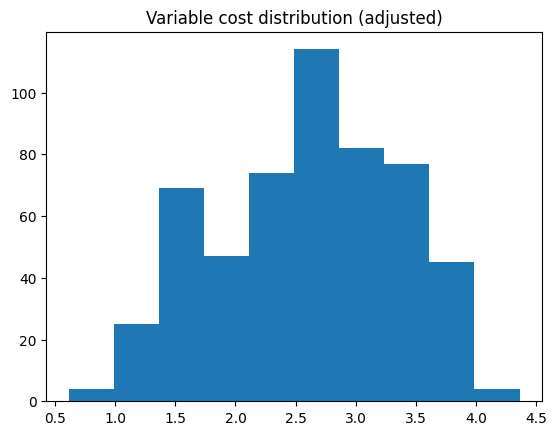

In [41]:
plt.hist(coal_savings_df[coal_savings_df[' VC'] != 0][' VC'].dropna())
plt.title('Variable cost distribution (adjusted)')

# Aspen Inputs

In [21]:
aspen_avg_inputs = pd.read_excel('TES_Assumptions_2023.xlsx',sheet_name="AspenInputs",header=1)
aspen_avg_inputs

,Variable Name,Units,Description,700MW,600MW,660MW,500MW,250MW,210MW,195_200MW,140MW,120_125MW,100_110MW
0,P_out,MW,Average Operating Values or design values,685,600,650,500,250,210.1,199,140.1,120.6,108.1
1,steam_eff,[0 - 1],steam turbine efficiency (not the full plant e...,0.48,0.463,0.463,0.435348,0.429309,0.424794,0.41939,0.4189,0.416992,0.40231
2,P_aux_TES,MW,Aux Power Consumption for TES,2.64,2.31,2.51,1.9345,0.96725,0.812877,0.769931,0.542047,0.466601,0.418239
3,P_aux_coal,MW,Aux Power Consumption for Coal,35,24,26.7,39.2,23.6,19,17.02,13.38,11.38,11.82
4,F_steam,kg/s,Flow rate of main steam,510,440,480,421.611111,207.861111,179.194444,178.416667,113.583333,104.111111,95.777778
5,Pressure_steam,bar,pressure of main steam,242,166.5,166.5,167.987291,147.687601,139.450045,133.075746,130.231828,127.38791,124.249794
6,Temperature_steam,C,peak steam temperature,560,560,560,537.6,537.6,537.3,538,539,537.4,537.5
7,Notes_Sources,NaN,NaN,[3],[3],[3],"[4],[5]","[4],[5]","[4],[5]","[4],[5]","[4],[5]","[4],[5]","[4],[5]"


In [22]:
aspen_avg_inputs['Variable Name']

0                P_out
1            steam_eff
2            P_aux_TES
3           P_aux_coal
4              F_steam
5       Pressure_steam
6    Temperature_steam
7        Notes_Sources
Name: Variable Name, dtype: object

In [24]:
tabs = pd.ExcelFile("data/report_CEA_edits.xlsx").sheet_names 

for tab in tabs:
    #read in the tab
    capacity_df  = pd.read_excel('data/report_CEA_edits.xlsx',sheet_name=tab)

    #get only the design data
    capacity_des_df = capacity_df[(capacity_df['Mode ']=='Design') | (capacity_df['Mode ']=='Design ')].reset_index(drop=True)
    #get only the operating
    capacity_op_df = capacity_df[(capacity_df['Mode ']=='Operating') | (capacity_df['Mode ']=='Operating ')].reset_index(drop=True)
    #make a new column in aspen file and populate with values and converted values
    for i in np.arange(len(capacity_des_df)):
        col_name = tab+'_'+str(i)
        aspen_avg_inputs[col_name]=np.zeros(len(aspen_avg_inputs))
        
        #set values
        #P_out
        aspen_avg_inputs.loc[aspen_avg_inputs['Variable Name']=='P_out',col_name] = capacity_des_df.loc[i,'Load']

        #design eff
        #steam_eff #kcal/kwh 1 kWh = 860.421 kcal
        aspen_avg_inputs.loc[aspen_avg_inputs['Variable Name']=='steam_eff',col_name] = 1/(capacity_des_df.loc[i,'TurbineHeatRate']/860.421)
        #operating eff
        #aspen_avg_inputs.loc[aspen_avg_inputs['Variable Name']=='steam_eff',col_name] = 1/(capacity_op_df.loc[i,'TurbineHeatRate']/860.421)

        #P_aux_TES #this is calculated another way 
        aspen_avg_inputs.loc[aspen_avg_inputs['Variable Name']=='P_aux_TES',col_name] = capacity_des_df.loc[i,'Load'] * 0.3869 / 100

        #P_aux_coal
        aspen_avg_inputs.loc[aspen_avg_inputs['Variable Name']=='P_aux_coal',col_name] = capacity_des_df.loc[i,'AuxPower'] * capacity_des_df.loc[i,'Load'] / 100

        #F_steam #tph to kg / s
        aspen_avg_inputs.loc[aspen_avg_inputs['Variable Name']=='F_steam',col_name] = capacity_des_df.loc[i,'Flow  '] * 1000 / (60*60)

        #Pressure_steam #1MPa = 10.1972 kg/cm2
        aspen_avg_inputs.loc[aspen_avg_inputs['Variable Name']=='Pressure_steam',col_name] = capacity_des_df.loc[i,'Pressure'] / 1.01972

        #Temperature_steam
        aspen_avg_inputs.loc[aspen_avg_inputs['Variable Name']=='Temperature_steam',col_name] = capacity_des_df.loc[i,'Temp']




In [25]:
aspen_avg_inputs.to_excel('data/aspen_data/AspenInputs_2.xlsx')

In [26]:
aspen_avg_inputs

,Variable Name,Units,Description,700MW,600MW,660MW,500MW,250MW,210MW,195_200MW,...,120_125MW_7,120_125MW_8,100_110MW_0,100_110MW_1,100_110MW_2,100_110MW_3,100_110MW_4,100_110MW_5,100_110MW_6,100_110MW_7
0,P_out,MW,Average Operating Values or design values,685,600,650,500,250,210.1,199,...,120.300000,125.000000,100.000000,105.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
1,steam_eff,[0 - 1],steam turbine efficiency (not the full plant e...,0.48,0.463,0.463,0.435348,0.429309,0.424794,0.41939,...,0.409724,0.425530,0.402442,0.402066,0.402442,0.405859,0.405859,0.402066,0.402066,0.402066
2,P_aux_TES,MW,Aux Power Consumption for TES,2.64,2.31,2.51,1.9345,0.96725,0.812877,0.769931,...,0.465441,0.483625,0.386900,0.406245,0.425590,0.425590,0.425590,0.425590,0.425590,0.425590
3,P_aux_coal,MW,Aux Power Consumption for Coal,35,24,26.7,39.2,23.6,19,17.02,...,16.324710,14.375000,19.760000,14.847000,16.841000,10.560000,10.021000,10.318000,14.344000,15.884000
4,F_steam,kg/s,Flow rate of main steam,510,440,480,421.611111,207.861111,179.194444,178.416667,...,95.555556,108.333333,116.666667,88.888889,90.555556,90.000000,90.000000,101.388889,98.333333,90.277778
5,Pressure_steam,bar,pressure of main steam,242,166.5,166.5,167.987291,147.687601,139.450045,133.075746,...,127.485977,129.447299,88.259522,127.878241,127.485977,126.505315,136.311929,134.840937,125.524654,127.485977
6,Temperature_steam,C,peak steam temperature,560,560,560,537.6,537.6,537.3,538,...,535.000000,540.000000,535.000000,535.000000,535.000000,540.000000,540.000000,540.000000,535.000000,540.000000
7,Notes_Sources,NaN,NaN,[3],[3],[3],"[4],[5]","[4],[5]","[4],[5]","[4],[5]",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## processing the Aspen outputs

In [5]:
aspen_outputs = pd.read_csv('data/aspen_data/output_df.csv') #divide all UA values by 10e6
aspen_outputs_500 = pd.read_csv('data/aspen_data/output_df_500.csv')

In [6]:
aspen_outputs.iloc[:,11:16]

,500MW_0,500MW_1,500MW_2,500MW_3,500MW_4
0,2.050681e-01,2.054956e-01,2.050681e-01,2.050935e-01,2.054404e-01
1,-3.467832e+06,-3.468597e+06,-3.467832e+06,-3.470464e+06,-3.468858e+06
2,5.448106e+02,5.391973e+02,5.382068e+02,5.396564e+02,5.403943e+02
3,9.609033e+02,1.030803e+03,1.100703e+03,1.170603e+03,1.240503e+03
4,2.785000e+01,2.685000e+01,2.785000e+01,2.685000e+01,2.685000e+01
5,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02,2.400000e+02
6,3.527778e+02,3.485017e+02,3.485017e+02,3.490278e+02,3.493056e+02
7,4.101361e-01,4.109911e-01,4.101361e-01,4.101870e-01,4.108807e-01
8,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02,4.750000e-02
9,5.910782e+02,5.914057e+02,5.910782e+02,5.920957e+02,5.915018e+02


In [7]:
#reset the 500 units 
aspen_outputs.iloc[:,11:16] = aspen_outputs_500.iloc[:,1:]

In [8]:
aspen_outputs = pd.read_csv('data/aspen_data/output_df_UP.csv')
aspen_outputs

,Unnamed: 0,700MW,600MW,660MW,500MW,250MW,210MW,195_200MW,140MW,120_125MW,...,100_110MW_3,100_110MW_4,100_110MW_5,100_110MW_6,100_110MW_7,500MW_0,500MW_1,500MW_2,500MW_3,500MW_4
0,steam_eff,4.246558e-01,4.149807e-01,4.149807e-01,4.104755e-01,4.068047e-01,4.050303e-01,4.037477e-01,4.032862e-01,4.022596e-01,...,4.025827e-01,4.049051e-01,4.045724e-01,4.012926e-01,4.028265e-01,4.101362e-01,4.109912e-01,4.101362e-01,4.101870e-01,4.108807e-01
1,Qs,-3.492277e+06,-3.519954e+06,-3.519954e+06,-3.468702e+06,-3.476428e+06,-3.478886e+06,-3.482870e+06,-3.486180e+06,-3.483687e+06,...,-3.489819e+06,-3.486117e+06,-3.486673e+06,-3.479046e+06,-3.489449e+06,-3.467832e+06,-3.468597e+06,-3.467832e+06,-3.470464e+06,-3.468858e+06
2,P_out_net,6.873597e+02,6.188276e+02,6.750847e+02,5.365357e+02,2.731827e+02,2.293506e+02,2.170711e+02,1.540523e+02,1.327185e+02,...,1.206465e+02,1.196248e+02,1.205262e+02,1.248782e+02,1.252635e+02,5.448106e+02,5.391973e+02,5.382068e+02,5.396564e+02,5.403943e+02
3,F_salt,4.842082e+03,4.434889e+03,4.838420e+03,3.889339e+03,1.995710e+03,1.681993e+03,1.596279e+03,1.134170e+03,9.795211e+02,...,8.897197e+02,8.778074e+02,8.851242e+02,9.238140e+02,9.231745e+02,3.952194e+03,3.904330e+03,3.904330e+03,3.914025e+03,3.914025e+03
4,deltaA,5.000589e+00,5.000523e+00,5.000523e+00,2.740076e+01,2.740062e+01,2.770055e+01,2.700048e+01,2.600043e+01,2.760042e+01,...,2.500038e+01,2.500049e+01,2.500047e+01,3.000042e+01,2.500039e+01,2.800077e+01,2.700077e+01,2.800077e+01,2.700075e+01,2.700077e+01
5,deltaB,9.173068e+01,1.265622e+02,1.265681e+02,1.356440e+02,1.469769e+02,1.517056e+02,1.551432e+02,1.564962e+02,1.586107e+02,...,1.583849e+02,1.527081e+02,1.535582e+02,1.603906e+02,1.578041e+02,1.365387e+02,1.340302e+02,1.365396e+02,1.367881e+02,1.344208e+02
6,deltaC,6.539801e+01,6.823338e+01,6.824434e+01,7.319593e+01,7.693026e+01,8.152040e+01,8.521722e+01,8.690643e+01,8.862607e+01,...,8.916987e+01,8.332274e+01,8.419311e+01,8.976832e+01,8.855824e+01,7.339087e+01,7.297851e+01,7.339245e+01,7.320907e+01,7.301550e+01
7,deltaD,2.550904e+02,2.432811e+02,2.433012e+02,2.435905e+02,2.492626e+02,2.435085e+02,2.434861e+02,2.434609e+02,2.434732e+02,...,2.434450e+02,2.434647e+02,2.434873e+02,2.434981e+02,2.434255e+02,2.435908e+02,2.435824e+02,2.435937e+02,2.435790e+02,2.435927e+02
8,flowsteamPeak,4.301515e+02,3.888889e+02,4.242424e+02,3.470839e+02,1.774168e+02,1.493287e+02,1.414718e+02,1.003893e+02,8.675926e+01,...,7.863636e+01,7.772727e+01,7.834596e+01,8.194444e+01,8.161476e+01,3.527778e+02,3.485017e+02,3.485017e+02,3.490278e+02,3.493056e+02
9,coal_steam_eff,4.318569e-01,4.162364e-01,4.162364e-01,4.104754e-01,4.068047e-01,4.050303e-01,4.037477e-01,4.032862e-01,4.022596e-01,...,4.025827e-01,4.049051e-01,4.045725e-01,4.012926e-01,4.028265e-01,4.101361e-01,4.109911e-01,4.101361e-01,4.101870e-01,4.108807e-01


In [9]:
#actually save this to a cleaned version 
aspen_outputs.to_csv('data/aspen_data/outputs_cleaned_df.csv')

In [10]:
aspen_outputs

,Unnamed: 0,700MW,600MW,660MW,500MW,250MW,210MW,195_200MW,140MW,120_125MW,...,100_110MW_3,100_110MW_4,100_110MW_5,100_110MW_6,100_110MW_7,500MW_0,500MW_1,500MW_2,500MW_3,500MW_4
0,steam_eff,4.246558e-01,4.149807e-01,4.149807e-01,4.104755e-01,4.068047e-01,4.050303e-01,4.037477e-01,4.032862e-01,4.022596e-01,...,4.025827e-01,4.049051e-01,4.045724e-01,4.012926e-01,4.028265e-01,4.101362e-01,4.109912e-01,4.101362e-01,4.101870e-01,4.108807e-01
1,Qs,-3.492277e+06,-3.519954e+06,-3.519954e+06,-3.468702e+06,-3.476428e+06,-3.478886e+06,-3.482870e+06,-3.486180e+06,-3.483687e+06,...,-3.489819e+06,-3.486117e+06,-3.486673e+06,-3.479046e+06,-3.489449e+06,-3.467832e+06,-3.468597e+06,-3.467832e+06,-3.470464e+06,-3.468858e+06
2,P_out_net,6.873597e+02,6.188276e+02,6.750847e+02,5.365357e+02,2.731827e+02,2.293506e+02,2.170711e+02,1.540523e+02,1.327185e+02,...,1.206465e+02,1.196248e+02,1.205262e+02,1.248782e+02,1.252635e+02,5.448106e+02,5.391973e+02,5.382068e+02,5.396564e+02,5.403943e+02
3,F_salt,4.842082e+03,4.434889e+03,4.838420e+03,3.889339e+03,1.995710e+03,1.681993e+03,1.596279e+03,1.134170e+03,9.795211e+02,...,8.897197e+02,8.778074e+02,8.851242e+02,9.238140e+02,9.231745e+02,3.952194e+03,3.904330e+03,3.904330e+03,3.914025e+03,3.914025e+03
4,deltaA,5.000589e+00,5.000523e+00,5.000523e+00,2.740076e+01,2.740062e+01,2.770055e+01,2.700048e+01,2.600043e+01,2.760042e+01,...,2.500038e+01,2.500049e+01,2.500047e+01,3.000042e+01,2.500039e+01,2.800077e+01,2.700077e+01,2.800077e+01,2.700075e+01,2.700077e+01
5,deltaB,9.173068e+01,1.265622e+02,1.265681e+02,1.356440e+02,1.469769e+02,1.517056e+02,1.551432e+02,1.564962e+02,1.586107e+02,...,1.583849e+02,1.527081e+02,1.535582e+02,1.603906e+02,1.578041e+02,1.365387e+02,1.340302e+02,1.365396e+02,1.367881e+02,1.344208e+02
6,deltaC,6.539801e+01,6.823338e+01,6.824434e+01,7.319593e+01,7.693026e+01,8.152040e+01,8.521722e+01,8.690643e+01,8.862607e+01,...,8.916987e+01,8.332274e+01,8.419311e+01,8.976832e+01,8.855824e+01,7.339087e+01,7.297851e+01,7.339245e+01,7.320907e+01,7.301550e+01
7,deltaD,2.550904e+02,2.432811e+02,2.433012e+02,2.435905e+02,2.492626e+02,2.435085e+02,2.434861e+02,2.434609e+02,2.434732e+02,...,2.434450e+02,2.434647e+02,2.434873e+02,2.434981e+02,2.434255e+02,2.435908e+02,2.435824e+02,2.435937e+02,2.435790e+02,2.435927e+02
8,flowsteamPeak,4.301515e+02,3.888889e+02,4.242424e+02,3.470839e+02,1.774168e+02,1.493287e+02,1.414718e+02,1.003893e+02,8.675926e+01,...,7.863636e+01,7.772727e+01,7.834596e+01,8.194444e+01,8.161476e+01,3.527778e+02,3.485017e+02,3.485017e+02,3.490278e+02,3.493056e+02
9,coal_steam_eff,4.318569e-01,4.162364e-01,4.162364e-01,4.104754e-01,4.068047e-01,4.050303e-01,4.037477e-01,4.032862e-01,4.022596e-01,...,4.025827e-01,4.049051e-01,4.045725e-01,4.012926e-01,4.028265e-01,4.101361e-01,4.109911e-01,4.101361e-01,4.101870e-01,4.108807e-01


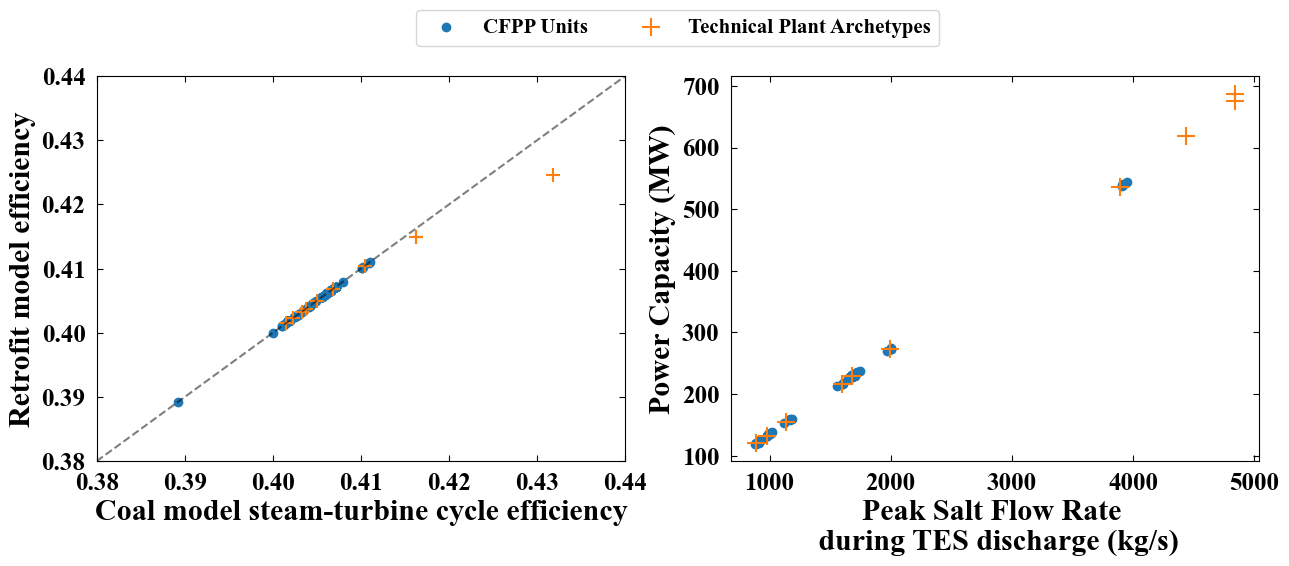

In [18]:


plotparams()


fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1, 2,wspace = 0.2)
(ax1, ax2 ) = gs.subplots()


ax1.axline((0, 0), slope=1,color='black',linestyle='--',alpha=0.5)

#plot efficiency of cfpp vs. the molten salt efficiency for all the units that aren't representative
ax1.scatter(aspen_outputs.iloc[9,11:],aspen_outputs.iloc[0,11:],color='tab:blue',label='historical operational data')
#plot them for the representative units
ax1.scatter(aspen_outputs.iloc[9,1:11],aspen_outputs.iloc[0,1:11],color='tab:orange',label='representative units',marker='+',s=150)

ax1.set_ylabel('Retrofit model efficiency')
ax1.set_xlabel('Coal model steam-turbine cycle efficiency')
# ax1.tick_params(labelsize=fs)
ax1.set_ylim(bottom=0.38,top=0.44)
ax1.set_xlim(left=0.38,right=0.44)

ax2.scatter(aspen_outputs.iloc[3,11:],aspen_outputs.iloc[2,11:],color='tab:blue',label='CFPP Units')

ax2.scatter(aspen_outputs.iloc[3,1:11],aspen_outputs.iloc[2,1:11],color='tab:orange',label='Technical Plant Archetypes',marker='+',s=150)
ax2.set_xlabel('Peak Salt Flow Rate \n during TES discharge (kg/s)')
ax2.set_ylabel('Power Capacity (MW)')


ax2.legend(loc='upper center', bbox_to_anchor=(-0.1, 1.2),prop=font, ncols = 2)

plt.savefig('figures/figures/AspenUnits',bbox_inches='tight',dpi=1000)


In [55]:
aspen_avg_inputs.iloc[1,18:]

250MW_0        0.429309
250MW_1        0.429352
250MW_2        0.429138
250MW_3        0.429352
250MW_4        0.429352
                 ...   
100_110MW_3    0.405859
100_110MW_4    0.405859
100_110MW_5    0.402066
100_110MW_6    0.402066
100_110MW_7    0.402066
Name: 1, Length: 80, dtype: object

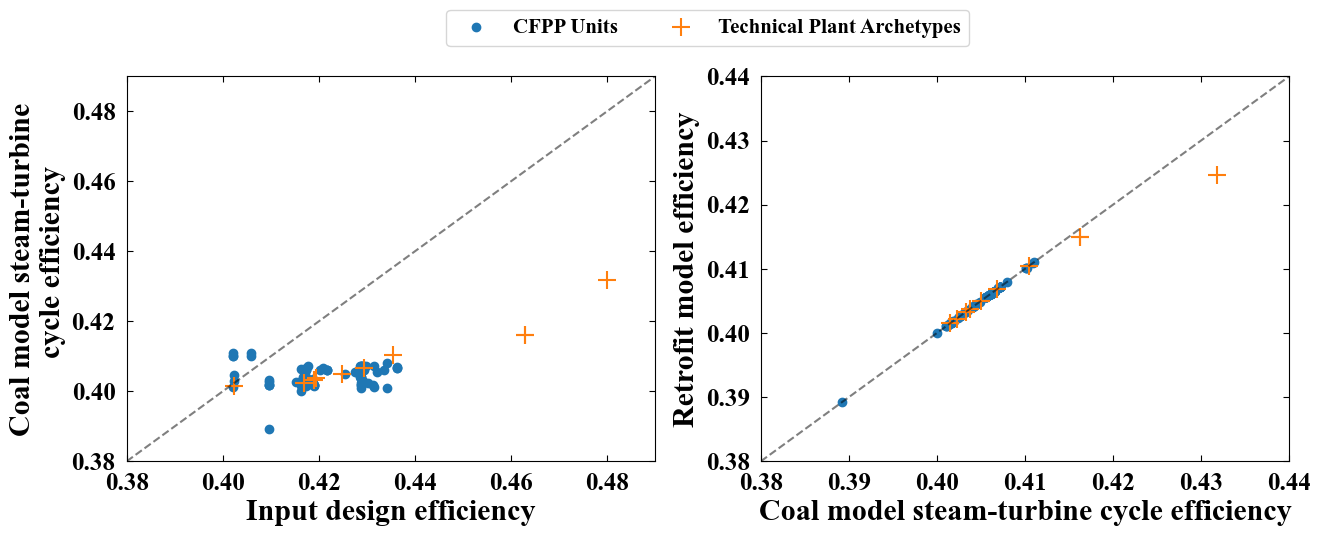

In [29]:

plotparams()

fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1, 2,wspace = 0.2)
(ax1, ax2 ) = gs.subplots()

ax1.scatter(aspen_avg_inputs.iloc[1,13:],aspen_outputs.iloc[9,11:],color='tab:blue',label='CFPP Units')
ax1.scatter(aspen_avg_inputs.iloc[1,3:13],aspen_outputs.iloc[9,1:11],color='tab:orange',label='Technical Plant Archetypes',marker='+',s=150)

ax1.axline((0, 0), slope=1,color='black',linestyle='--',alpha=0.5)


ax1.set_ylabel('Coal model steam-turbine\n  cycle efficiency')#,fontsize=fs)
ax1.set_xlabel('Input design efficiency')#,fontsize=fs)
# ax1.tick_params(labelsize=fs)
ax1.set_ylim(bottom=0.38,top=0.49)
ax1.set_xlim(left=0.38,right=0.49)


ax2.axline((0, 0), slope=1,color='black',linestyle='--',alpha=0.5)

#plot efficiency of cfpp vs. the molten salt efficiency for all the units that aren't representative
ax2.scatter(aspen_outputs.iloc[9,11:],aspen_outputs.iloc[0,11:],color='tab:blue',label='CFPP Units')
#plot them for the representative units
ax2.scatter(aspen_outputs.iloc[9,1:11],aspen_outputs.iloc[0,1:11],color='tab:orange',label='Technical Plant Archetypes',marker='+',s=150)

ax2.set_ylabel('Retrofit model efficiency')#,fontsize=fs)
ax2.set_xlabel('Coal model steam-turbine cycle efficiency')#,fontsize=fs)
# ax2.tick_params(labelsize=fs)

ax2.set_ylim(bottom=0.38,top=0.44)
ax2.set_xlim(left=0.38,right=0.44)


ax2.legend(loc='upper center', bbox_to_anchor=(-0.1, 1.2),prop=font, ncols = 2)

plt.savefig('figures/figures/AspenUnits_SI',bbox_inches='tight',dpi=1000)


# Clusters from Aspen Outputs to Optimization

In [58]:
# coal plant dictionary by unit 
folder = 'model/UttarPradesh/'

coalplant_clusters = pd.read_csv(folder+'outputs_cleaned_df.csv').set_index("Unnamed: 0")
coalplant_clusters

FileNotFoundError: [Errno 2] No such file or directory: 'TrombayU5_repweeks/UttarPradesh/output_df.csv'

In [59]:
#add to coal savings
#initialize the columns
for var in coalplant_clusters.index:
    coal_savings_df[var]=np.zeros(len(coal_savings_df))
    #map values, anything less than 110 MW - basic interpolation method that can be changed
    coal_savings_df.loc[coal_savings_df.Capacity<117,var] = coalplant_clusters.loc[var,'100_110MW']
    coal_savings_df.loc[(coal_savings_df.Capacity>=117)&(coal_savings_df.Capacity<130),var] = coalplant_clusters.loc[var,'120_125MW']
    coal_savings_df.loc[(coal_savings_df.Capacity>=130)&(coal_savings_df.Capacity<168),var] = coalplant_clusters.loc[var,'140MW']
    coal_savings_df.loc[(coal_savings_df.Capacity>=168)&(coal_savings_df.Capacity<205),var] = coalplant_clusters.loc[var,'195_200MW']
    coal_savings_df.loc[(coal_savings_df.Capacity>=205)&(coal_savings_df.Capacity<230),var] = coalplant_clusters.loc[var,'210MW']
    coal_savings_df.loc[(coal_savings_df.Capacity>=230)&(coal_savings_df.Capacity<375),var] = coalplant_clusters.loc[var,'250MW']
    coal_savings_df.loc[(coal_savings_df.Capacity>=375)&(coal_savings_df.Capacity<550),var] = coalplant_clusters.loc[var,'500MW']
    coal_savings_df.loc[(coal_savings_df.Capacity>=550)&(coal_savings_df.Capacity<630),var] = coalplant_clusters.loc[var,'600MW']
    coal_savings_df.loc[(coal_savings_df.Capacity>=630)&(coal_savings_df.Capacity<680),var] = coalplant_clusters.loc[var,'660MW']
    coal_savings_df.loc[coal_savings_df.Capacity>=680,var] = coalplant_clusters.loc[var,'700MW']


NameError: name 'coalplant_clusters' is not defined

In [ ]:
coalplant_clusters.index

Index(['steam_eff', 'Qs', 'P_out_net', 'F_salt', 'deltaA', 'deltaB', 'deltaC',
       'deltaD', 'flowsteamPeak', 'coal_steam_eff', 'target_pressure',
       'HP_input_T_MS', 'HP_output_T_MS', 'HP_output_P_MS', 'IP_input_T_MS',
       'IP_input_P_MS', 'LP_input_T_MS', 'LP_input_P_MS', 'LP_output_T_MS',
       'LP_output_P_MS', 'LP_vaporfraction_MS', 'HP_output_T_coal',
       'HP_output_P_coal', 'IP_input_T_coal', 'IP_input_P_coal',
       'LP_input_T_coal', 'LP_input_P_coal', 'LP_output_T_coal',
       'LP_output_P_coal', 'LP_vaporfraction_coal', 'coal_power_net',
       'flowsteam_calibrated', 'cold_salt_temp', 'steam_peak_temp',
       'lmtd_salt', 'UA'],
      dtype='object', name='Unnamed: 0')

In [60]:
coal_savings_df

,Unit ID,Plant name,State,Region,Ownership,Age grouping,Age,Capacity,Avg daily generation,Unnamed: 9,...,Actual - pvt,Reallocated-pvt,Actual-cons,Reallocated cons,Actual age,Reallocated age,Actual capacity,Reallocated capacity,Actual aux,Reallocated aux
1,DARLIPALI STPS1,DARLIPALI STPS,Odisha,ER,CENTRAL SECTOR,0-5 years,0.342231,800.0,0.112473,NaN,...,0.000000,0.0,7.330362e+04,10636453.92,285.012732,41355.728953,-5.415806e+04,-7858406.4,2.378525e+04,3.451272e+06
2,GADARWARA TPP1,GADARWARA TPP,Madhya Pradesh,WR,CENTRAL SECTOR,0-5 years,1.067762,800.0,3.301005,NaN,...,0.000000,0.0,2.151409e+06,10636453.92,26098.547291,129029.874333,-1.589500e+06,-7858406.4,6.862969e+05,3.393017e+06
3,KOTHAGUDEM STAGE-7 TPS12,KOTHAGUDEM STAGE-7 TPS,Telangana,SR,STATE SECTOR,0-5 years,1.960301,800.0,12.164454,NaN,...,0.000000,0.0,7.928104e+06,10636453.92,176567.664375,236885.615441,-5.857428e+06,-7858406.4,2.407261e+06,3.229615e+06
4,LARA TPP1,LARA TPP,Chhattisgarh,WR,CENTRAL SECTOR,0-5 years,2.091718,800.0,3.669757,NaN,...,0.000000,0.0,2.391740e+06,10636453.92,56837.654282,252766.215359,-1.767061e+06,-7858406.4,5.445551e+05,2.421724e+06
5,YERMARUS TPS2,YERMARUS TPS,Karnataka,SR,STATE SECTOR,0-5 years,3.091034,800.0,0.780441,NaN,...,0.000000,0.0,5.086475e+05,10636453.92,17862.393530,373524.943901,-3.757981e+05,-7858406.4,2.917027e+05,6.099867e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,WANAKBORI TPS6,WANAKBORI TPS,Gujarat,WR,STATE SECTOR,30-35 years,32.506502,210.0,2.924383,NaN,...,0.000000,NaN,1.905948e+06,NaN,703882.581792,NaN,-3.696391e+05,NaN,7.647047e+05,NaN
538,WANAKBORI TPS7,WANAKBORI TPS,Gujarat,WR,STATE SECTOR,20-25 years,21.423682,210.0,3.871361,NaN,...,0.000000,NaN,2.523134e+06,NaN,614120.374770,NaN,-4.893361e+05,NaN,1.012333e+06,NaN
539,WARDHA WARORA TPP2,WARDHA WARORA TPP,Maharashtra,WR,PVT SECTOR,5-10 years,9.590691,135.0,0.116512,NaN,...,-42997.991735,NaN,7.593575e+04,NaN,8273.994016,NaN,-9.467333e+03,NaN,3.656017e+04,NaN
540,WARDHA WARORA TPP3,WARDHA WARORA TPP,Maharashtra,WR,PVT SECTOR,5-10 years,9.338809,135.0,0.896086,NaN,...,-330695.463275,NaN,5.840181e+05,NaN,61963.629666,NaN,-7.281280e+04,NaN,2.811825e+05,NaN


In [61]:
#data of coal fleet from CEEW
data_df = pd.DataFrame(coal_savings_df.groupby(['State','Age grouping','Capacity']).mean())
data_df['Unit ID'] = coal_savings_df.groupby(['State','Age grouping','Capacity'])['Unit ID'].apply(list)

#define group ID
data_df['Group ID'] = ['Group'+str(i) for i in np.arange(len(data_df))]

#save coal_savings_df
coal_savings_df.to_csv(folder+'coal_savings_adjusted_df.csv',index=False)

#get only the UP plants
UP_clusters = data_df.loc['Uttar Pradesh',:]

#adjusted efficiency by assumed boiler efficiency to reflect steam-turbine efficiency
#save UPclusters
UP_clusters.to_csv(folder+'UPclusters.csv',index=True)

#set the maximum lifetime
max_lifetime = 50

UP_clusters.head()

/var/folders/d2/m883jtg90djc2d9b2sq68hp80000gn/T/ipykernel_37962/3932571560.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_df = pd.DataFrame(coal_savings_df.groupby(['State','Age grouping','Capacity']).mean())


Age  Avg daily generation  Unnamed: 9  \
Age grouping Capacity                                                
 0-5 years   500.0      3.175907              3.897856         NaN   
             600.0      4.550308              8.392746         NaN   
             660.0      3.300479              6.302793    8.655455   
 10-15 years 210.0     13.757700              3.277626         NaN   
             300.0     10.253251              3.877207         NaN   

                       Actual avg PLF  Target PLF  PLF Diff  \
Age grouping Capacity                                         
 0-5 years   500.0           0.324821      0.8500  0.525179   
             600.0           0.582830      0.8500  0.267170   
             660.0           0.397904      0.8500  0.452096   
 10-15 years 210.0           0.650323      0.8000  0.149677   
             300.0           0.538501      0.4925 -0.046001   

                       Coeff of variation  \
Age grouping Capacity                       
 0-5 years   500.0                   0.15   
             600.0                   0.15   
             660.0                   0.15   
 10-15 years 210.0                   0.15   
             300.0                   0.25   

                       Daily actual coal consumption - calc (tons/MW)  \
Age grouping Capacity                                                   
 0-5 years   500.0                                           5.465556   
             600.0                                           8.578046   
             660.0                                           4.985740   
 10-15 years 210.0                                          11.839822   
             300.0                                           8.785639   

                       Annual actual coal consumption (tons)  \
Age grouping Capacity                                          
 0-5 years   500.0                              9.974640e+05   
             600.0                              1.878592e+06   
             660.0                              1.201065e+06   
 10-15 years 210.0                              9.075224e+05   
             300.0                              9.620275e+05   

                       Daily target coal consumption at 85%(tons/MW)  ...  \
Age grouping Capacity                                                 ...   
 0-5 years   500.0                                         12.772524  ...   
             600.0                                         12.295268  ...   
             660.0                                         11.275893  ...   
 10-15 years 210.0                                         14.617994  ...   
             300.0                                         13.119618  ...   

                        Actual-cons  Reallocated cons     Actual age  \
Age grouping Capacity                                                  
 0-5 years   500.0     2.540402e+06       6647783.700   91661.997154   
             600.0     5.469917e+06       7977340.440  285897.284134   
             660.0     4.107804e+06       8775074.484  151947.073533   
 10-15 years 210.0     2.136171e+06               NaN  333696.371969   
             300.0     2.526945e+06       2311082.451  294358.332743   

                       Reallocated age  Actual capacity  Reallocated capacity  \
Age grouping Capacity                                                           
 0-5 years   500.0       239863.227926    -1.173060e+06          -3069690.000   
             600.0       412399.329117    -3.030956e+06          -4420353.600   
             660.0       329038.586267    -2.503810e+06          -5348627.856   
 10-15 years 210.0                 NaN    -4.142886e+05                   NaN   
             300.0       269213.023860    -7.001073e+05           -640301.220   

                         Actual aux  Reallocated aux  \
Age grouping Capacity                                  
 0-5 years   500.0     1.111148e+06     2.907678e+06   
             600.0     2.212648e+06   

In [258]:
#checking for nans

for col in UP_clusters.columns:
    sumnan = sum(UP_clusters[col].isna())
    if sumnan > 0:
        print(col, sumnan)

Unnamed: 9 25
Annual target coal consumption (tons) 12
Target coal used 12
BCCL 1
CCL 1
ECL 1
MCL 1
NCL 1
NEC 1
SECL 1
WCL 1
Targeted aux, MU 12
VC - TARGET 12
Diff 12
Fixed cost for FY 2018-19 (INR crore) 16
Unnamed: 53 26
Sox control cost (INR crore) 18
Nox control cost (INR crore) 18
Unnamed: 61 26
ramp up (%/min) 9
ramp down (%/min) 9
wtd ramp up 9
wtd ramp down 9
Unnamed: 68 26
Target energy 12
Target energy-coal cost 12
Target energy-transport cost 12
Reallocated SHR 12
Reallocated INR/Mcal 12
Reallocated PLF 12
Reallocated-pvt 12
Reallocated cons 12
Reallocated age 12
Reallocated capacity 12
Reallocated aux 12


In [259]:
print(sum(coal_savings_df['ramp up (%/min)'].isna())/len(coal_savings_df)*100, '% of the ceew dataset is nan for ramp rates')


36.78373382624769 % of the ceew dataset is nan for ramp rates


## 2030 clusters for optimization

In [65]:
folder = 'RESULTS/UttarPradesh/'

In [66]:
#make a TES parameters file for each UP cluster and each sensitivity 
UP_clusters = pd.read_csv(folder+'UPclusters.csv')

#make a different parameters file for each type
for i in np.arange(len(UP_clusters)):
    
    #current age in years, added 9 to reflect 2030 or 29 for 2050
    age = int(UP_clusters.loc[i,"Age"]) #+9 #add 9 years to reflect the 2030 price profile

    #change to remaining lifetime in 2030
    remaining_life = np.round(max_lifetime - age)
    if math.isnan(remaining_life):
            print('its remaining life')
    
    #if remaining life is negative, then incurr the upgrade cost penalty- should not work 
    if remaining_life <= 0:
        TES_parameters.loc[0,"life"] = 25
        TES_parameters.loc[0,"upgrade_costs"] = 1220.77 
        print(i)
        
    else:
        TES_parameters.loc[0,"life"] = remaining_life

    #change the efficiency
    #adjusted efficiency by assumed boiler efficiency to reflect steam-turbine efficiency
    TES_parameters.loc[0,"steam_eff"] = np.round(UP_clusters.loc[i,"steam_eff"],3) #perhaps should have made this more granular

    #uncomment to change the capacity to whichever is lower
    #interconnection_capacity = min([UP_clusters.loc[i,"Capacity"],UP_clusters.loc[i,"P_out_net"]])

    interconnection_capacity = UP_clusters.loc[i,"Capacity"]

    TES_parameters.loc[0,"dischargepowerPeak"] = np.round(interconnection_capacity,2)

    TES_parameters.loc[0,"powerPeak"] = np.round(interconnection_capacity,2)

    TES_parameters.loc[0,"chargepowerPeak"] = np.round(interconnection_capacity,2)

    #change Qs
    TES_parameters.loc[0,"Q_s"] = np.round(UP_clusters.loc[i,"Qs"]/-1000)

    #change deltaA
    TES_parameters.loc[0,"deltaT_A"] = np.round(UP_clusters.loc[i,"deltaA"])

    #change deltaB
    TES_parameters.loc[0,"deltaT_B"] = np.round(UP_clusters.loc[i,"deltaB"])

    #change deltaB
    TES_parameters.loc[0,"deltaT_C"] = np.round(UP_clusters.loc[i,"deltaC"])

    #change deltaB
    TES_parameters.loc[0,"deltaT_D"] = np.round(UP_clusters.loc[i,"deltaD"])

    #change flowsteamPeak
    TES_parameters.loc[0,"flowsteam_peak"] = np.round(UP_clusters.loc[i,"flowsteamPeak"])

    #document the Group IDs
    GroupID = UP_clusters.loc[i,"Group ID"]
    TES_parameters.loc[0,"Group_ID"] = GroupID[5:] #take only the number 

    
    tonperMWh = UP_clusters.loc[i,"Actual SHR"]/UP_clusters.loc[i,"GCV"]

    if math.isnan(tonperMWh):
        print('ton per mwh', GroupID[5:])
    
    #coal_fuel_cost = 
    TES_parameters.loc[0,"coal_fuel_cost"] = np.round(UP_clusters.loc[i,"GCV"]*UP_clusters.loc[i,"INR/Mcal"]*tonperMWh/conversion/1000) #$1/tonne * tonne coal per MWh = $1k per MWh
    
    TES_parameters.loc[0,"coal_VOM"] = np.round(UP_clusters.loc[i," VC"]/conversion) #$/kWh = $1k/MWh
    
    if (math.isnan(TES_parameters.loc[0,"coal_fuel_cost"])) | (TES_parameters.loc[0,"coal_fuel_cost"]<=0):
        print('coal fuel cost', GroupID[5:])
        print(TES_parameters.loc[0,"coal_fuel_cost"])
           
    for min_hours in np.arange(0,11):
        TES_parameters.loc[0,'min_hours'] = min_hours
     
        #SAVE FILE
        TES_parameters.to_csv(folder+'parameters/'+str(GroupID) +'_' + str(int(min_hours)) 
                              + 'hrs.csv', index=False)
        

coal fuel cost 186
0.0
coalvom 186
0.0
coal fuel cost 187
0.0
coalvom 187
0.0
coal fuel cost 188
0.0
coalvom 188
0.0
coal fuel cost 189
0.0
coalvom 189
0.0
coal fuel cost 190
0.0
coalvom 190
0.0
coal fuel cost 191
0.0
coalvom 191
0.0
coal fuel cost 192
0.0
coalvom 192
0.0
coal fuel cost 193
0.0
coalvom 193
0.0
coal fuel cost 194
0.0
coalvom 194
0.0
coal fuel cost 195
0.0
coalvom 195
0.0
coal fuel cost 196
0.0
coalvom 196
0.0
coal fuel cost 197
0.0
coalvom 197
0.0
coal fuel cost 198
0.0
coalvom 198
0.0
coal fuel cost 199
0.0
coalvom 199
0.0
coal fuel cost 200
0.0
coalvom 200
0.0
coal fuel cost 201
0.0
coalvom 201
0.0
coal fuel cost 202
0.0
coalvom 202
0.0
coal fuel cost 203
0.0
coalvom 203
0.0
coal fuel cost 204
0.0
coalvom 204
0.0
19
coal fuel cost 205
0.0
coalvom 205
0.0
coal fuel cost 206
0.0
coalvom 206
0.0
coal fuel cost 207
0.0
coalvom 207
0.0
coal fuel cost 208
0.0
coalvom 208
0.0
coal fuel cost 209
0.0
coalvom 209
0.0
coal fuel cost 210
0.0
coalvom 210
0.0
coal fuel cost 211
0.0

# fin